In [1]:

import os
import time
import json
from pathlib import Path
from datetime import datetime

import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, IterableDataset, DataLoader

import ot as pot
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.optimal_transport import *

from random_processes import *
from models import *

from tqdm import tqdm
from tqdm.auto import trange
from rich.console import Console
from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn



In [2]:
# Some configurations and utilities

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed initialization
def init_seed(use_fixed=True, fixed_seed=42):
    if use_fixed:
        seed = fixed_seed
    else:
        seed = int.from_bytes(os.urandom(64), "little")
    print(f"Using seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

init_seed(use_fixed=True, fixed_seed=42)


# Saving directories
savedir = Path("savedir/MaskedCFM")
savedir.mkdir(parents=True, exist_ok=True)

def snapshot_state_dict(state):
    out = {}
    for k, v in state.items():
        if torch.is_tensor(v):
            out[k] = v.detach().clone().cpu()
        elif isinstance(v, dict):
            out[k] = snapshot_state_dict(v)
        else:
            out[k] = v
    return out

def prepare_run_folder(root: Path):
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = root / stamp
    run_dir.mkdir(parents=True, exist_ok=True)
    return stamp, run_dir

run_id, run_dir = prepare_run_folder(savedir)
(loss_plots_path, samples_fig_path) = (run_dir / "val_metrics.png", run_dir / "forward_samples.png")

def to_serializable(obj):
    if torch.is_tensor(obj):
        return obj.detach().cpu().tolist()
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_serializable(v) for v in obj]
    return obj


Using seed: 42


In [3]:
class RandomGeneratorDataset(IterableDataset):
    def __init__(self, sampler: Sampler, batch_size=1, device="cpu"):
        self.sampler = sampler
        self.batch_size = int(batch_size)
        self.device = device

    def set_batch_size(self, batch_size):
        """Update the batch size; takes effect on the next iteration."""
        self.batch_size = int(batch_size)

    def __iter__(self):
        while True:
            yield self.sampler.sample(self.batch_size).to(self.device)

    def state_dict(self):
        return {
            "sampler": {
                "class": self.sampler.__class__.__name__,
                "state": self.sampler.state_dict(),
            },
            "batch_size": self.batch_size,
            "device": str(self.device),
        }

    @classmethod
    def from_state_dict(cls, state, sampler_cls_map):
        sampler_info = state["sampler"]
        sampler_cls = sampler_cls_map[sampler_info["class"]]
        sampler = sampler_cls.from_state_dict(sampler_info["state"])
        return cls(sampler, batch_size=state["batch_size"], device=state["device"])

Conditional Sample Paths: $X_t \mid z = (x_0,x_1)$

1) Noisy Straight Paths: $ X_t = (1-t) x_0 + t x_1 + \sigma \epsilon $ where $\epsilon \sim \mathcal{N}(0, I)$.

2) Brownian Bridge Paths: $X_t = (1-t) x_0 + t x_1 + \sigma Z_t$ where $Z_t = W_t - tW_1$ is the Brownian bridge and $W_t$ is the standard Wiener process. Alternatively, $dZ_t = \frac{-Z_t}{1-t} dt + dW_t$ with $Z_0 = 0$ so that $dX_t = \frac{x_1-X_t}{1-t} dt + \sigma dW_t$ with $X_0 = x_0$.

Conditional veocity field: $u(x,t \mid z)$ where $z= (x_0,x_1)$

1) Noisty Straight Paths: $u(x,t \mid z) = x_1 - x_0$ 
2) Brownian Bridge Paths: 
$$
u(x,t \mid z) = \frac{x_1 - x}{1-t} - \frac{\sigma^2}{2}\nabla \log p(x,t\mid z)
$$ 
where 
$$
p(x,t\mid z) = \mathcal{N}(x\mid m_t(z),\, \sigma^2 t(1-t) I),\quad m_t(z) = (1-t) x_0 + tx_1
$$
is the marginal distribution of the Brownian bridge between $x_0$ and $x_1$ at time $t\in [0,1]$. In closed form, this leads to 
$$
u(x,t \mid z) = (x_1-x_0) + \frac{1-2t}{2t(1-t)} (x - m_t(z)).
$$ 


In [4]:
# --------------------------------------------------------------------------- #
# Conditional path / vector field utilities
# --------------------------------------------------------------------------- #
def SampleConditionalNoisyStraightPath(x0, x1, t, sigma=0.01):
    """Linear interpolation with Gaussian noise."""
    t = t.view(-1, 1)
    noise = sigma * torch.randn_like(x0)
    return (1.0 - t) * x0 + t * x1 + noise


def ConditionalVelocityField(x0, x1, t):
    """Analytic velocity for the straight-line homotopy."""
    _ = t  # unused but kept for API compatibility
    return x1 - x0


def SampleConditionalBrownianBridgePath(x0, x1, t, sigma=0.01):
    """
    Draw a sample from the probability path xt = (1 - t) * x0 + t * x1 + sigma * (Wt - t * W1)
    where Wt is a standard Brownian motion.
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma * torch.sqrt(t * (1 - t))  #FIX THIS, should be Brownian bridge stddev
    epsilon = torch.randn_like(x0)             #FIX THIS, should be Brownian bridge noise
    return mu_t + sigma_t * epsilon

Sampler from stochastically driven Lorenz attractor

In [5]:
lorenz_drift, lorenz_diff = lorenz_system(sigma=10.0, rho=28.0, beta=8/3, noise_scale=0.5)

def lorenz_init_sampler(batch_size):
    return torch.empty(batch_size, 3).uniform_(-15, 15)

T = 50

lorenz_sampler = SDESampler(
    drift_fn=lorenz_drift,
    diffusion_fn=lorenz_diff,
    t0=0.0,
    t1=1.0,
    steps=T-1,
    init_sampler=lorenz_init_sampler,
    method="euler",
)

Sampler from a Gaussian process with RBF kernel

In [6]:
dim = 2
T = 50
t_min, t_max = 0.0, 1.0

mean_fn = build_mean_fn("spiral", {"freq": 5.0})
A = torch.tensor([[1.0, 0.3], [0.3, 0.8]])
cov_kernel = build_kernel("rbf", {"sigma": 1.0, "tau": 5.0, "Cov": A})

times = torch.linspace(t_min, t_max, T)
gp_sampler = GPSampler(mean_fn=mean_fn, cov_kernel=cov_kernel, times=times, ldl_decomp=True, jitter=1e-4)
gp_mean, gp_cov = gp_sampler.get_stats()


std_gaussian_sampler = GaussianVectorSampler(dim=dim, T=T)
std_gaussian_mean, std_gaussian_cov = std_gaussian_sampler.get_stats(flatten=False)

#var = 0.01 

mean_prior = std_gaussian_mean.reshape(-1).to(device)
mean_target = gp_mean.reshape(-1).to(device)

prior_sampler = std_gaussian_sampler
target_sampler = gp_sampler

In [7]:
# --------------------------------------------------------------------------- #
# Evaluation helpers
# --------------------------------------------------------------------------- #
def evaluate_forward(bundle, label, batch_size, target_mean, T):
    with torch.no_grad():
        preds = bundle.forward_map(batch_size=batch_size, flatten=True)
    true_target_samples = bundle._draw_target(batch_size)
    target_mean = target_mean.to(preds.device)
    mean_pred = preds.mean(dim=0)
    std_pred = preds.std(dim=0)
    diff_mean = mean_pred - target_mean
    mean_err = torch.sqrt(torch.sum(diff_mean ** 2) / T).item()
    diff_samples = preds - target_mean
    sample_err = torch.sqrt(torch.mean(torch.sum(diff_samples ** 2, dim=1) / T)).item()

    w2 = wasserstein(preds, true_target_samples, method="exact", power=2)
    w2_dist = math.sqrt((w2 ** 2) / T)
    w2_dist = float(w2_dist)  # ensure plain float

    #print(f'{w2_dist}')
 
    return {
        "label": label,
        "mean_pred": mean_pred.cpu(),
        "std_pred": std_pred.cpu(),
        "mean_diff_target": mean_err,
        "mean_dev_target": sample_err,
        "w2_dist": w2_dist,
    }


def evaluate_backward(bundle, label, batch_size, prior_mean, T):
    with torch.no_grad():
        preds = bundle.backward_map(batch_size=batch_size, flatten=True)
    true_prior_samples = bundle._draw_prior(batch_size)
    prior_mean = prior_mean.to(preds.device)
    mean_pred = preds.mean(dim=0)
    std_pred = preds.std(dim=0)
    diff_mean = mean_pred - prior_mean
    mean_err = torch.sqrt(torch.sum(diff_mean ** 2) / T).item()
    diff_samples = preds - prior_mean
    sample_err = torch.sqrt(torch.mean(torch.sum(diff_samples ** 2, dim=1) / T)).item()

    w2 = wasserstein(preds, true_prior_samples, method="exact", power=2)
    w2_dist = math.sqrt((w2 ** 2) / T)
    w2_dist = float(w2_dist)  # ensure plain float

    #print(f'{w2_dist}')
    
    return {
        "label": label,
        "mean_pred": mean_pred.cpu(),
        "std_pred": std_pred.cpu(),
        "mean_diff_prior": mean_err,
        "mean_dev_prior": sample_err,
        "w2_dist": w2_dist,
    }

Independent coupling:
$$ \pi(dx_0, dx_1) = q_0(dx_0) q_1(dx_1)$$

In [ ]:
dim_w = 16 #hidden layers dimension per T
num_layers = 3
model_causal = MaskedBlockMLP(T=T, in_dim=dim, out_dim=dim, hidden_per_t=(dim_w,) * num_layers, causal=True, time_varying=True) 
model_full   = MaskedBlockMLP(T=T, in_dim=dim, out_dim=dim, hidden_per_t=(dim_w,) * num_layers, causal=False, time_varying=True) 

def make_node(model : torch.nn.Module):
    return NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

bundle_causal = CFMModelBundle(
    model=model_causal,
    cond_path_fn=SampleConditionalNoisyStraightPath,
    cond_vec_field_fn=ConditionalVelocityField,
    prior_sampler=prior_sampler,
    target_sampler=target_sampler,
    ode_factory=make_node,
    device=device,
)

bundle_full = CFMModelBundle(
    model=model_full,
    cond_path_fn=SampleConditionalNoisyStraightPath,
    cond_vec_field_fn=ConditionalVelocityField,
    prior_sampler=prior_sampler,
    target_sampler=target_sampler,
    ode_factory=make_node,
    device=device,
)

In [ ]:
batch_size = 2**12
batch_val = 2**12
num_steps = 2000
eval_every = 50
lr_causal, lr_full = 1e-3, 1e-3

train_history = []
val_history = []
checkpoints = []  

# hyperparameter tuning toolbox
# take all the params to serach over adn set tols and check inferenec over the criteria
# sweeps 
# 
# mit engaging cluster
# supercloud lincoln labs
# 
# transformer based arch for reproducing 
# this arch is pushing us along the lines of video arch (3dunets, uvit, dit)
# non of them causal (fogure out to make causal, dit should be easiest then the other two)
# implement these arch to scale up to real datasets
# 
# nn.Module.list

optimizer_causal = torch.optim.Adam(model_causal.parameters(), lr=lr_causal)
optimizer_full   = torch.optim.Adam(model_full.parameters(), lr=lr_causal)

console = Console(force_jupyter=True)  # ensures Rich draws in notebooks

def snapshot_state_dict(state_dict):
    return {k: v.clone().cpu() if torch.is_tensor(v) else v for k, v in state_dict.items()}

with Progress(
        TextColumn("{task.description}"),
        BarColumn(),
        TextColumn("Step {task.fields[step]:>4}/{task.total}"),
        TextColumn(
            "train (c/f) {task.fields[loss_c]:>6.4f}/{task.fields[loss_f]:>6.4f}\n"
            "FORE(c/f) mean_dif {task.fields[F_c_mean]:>6.4f}/{task.fields[F_f_mean]:>6.4f} | "
            "sample_dev {task.fields[F_c_sample]:>6.4f}/{task.fields[F_f_sample]:>6.4f} | " 
            "w2 {task.fields[F_c_was]:>6.4f}/{task.fields[F_f_was]:>6.4f} \n"
            "BACK(c/f) mean_dif {task.fields[B_c_mean]:>6.4f}/{task.fields[B_f_mean]:>6.4f} | "
            "sample_dev {task.fields[B_c_sample]:>6.4f}/{task.fields[B_f_sample]:>6.4f} | "
            "w2 {task.fields[B_c_was]:>6.4f}/{task.fields[B_f_was]:>6.4f}"
        ),
        TimeElapsedColumn(),
        TimeRemainingColumn(),
        console=console,
        refresh_per_second=1
    ) as progress:
        task_id = progress.add_task(
            "Training",
            total=num_steps,
            step=0,
            loss_c=0.0,
            loss_f=0.0,
            F_c_mean=0.0,
            F_c_sample=0.0,
            F_c_was=0.0,
            F_f_mean=0.0,
            F_f_sample=0.0,
            F_f_was=0.0,
            B_c_mean=0.0,
            B_c_sample=0.0,
            B_c_was=0.0,
            B_f_mean=0.0,
            B_f_sample=0.0,
            B_f_was=0.0,
        )


        for step in range(num_steps):
            optimizer_causal.zero_grad()
            optimizer_full.zero_grad()

            shared = bundle_causal.draw_samples(batch_size)
            loss_causal = bundle_causal.loss(batch_size, shared_data=shared)
            loss_full = bundle_full.loss(batch_size, shared_data=shared)

            loss_causal.backward()
            loss_full.backward()
            optimizer_causal.step()
            optimizer_full.step()
            train_history.append({
                "step": step + 1,
                "loss_causal": float(loss_causal.detach()),
                "loss_full": float(loss_full.detach()),
            })

            fields = {
                "step": step + 1,
                "loss_c": loss_causal.item(),
                "loss_f": loss_full.item(),
            }

            if (step + 1) % eval_every == 0:
                forward_stats_causal = evaluate_forward(bundle_causal, "causal", batch_val, mean_target, T)
                forward_stats_full = evaluate_forward(bundle_full, "full", batch_val, mean_target, T)
                backward_stats_causal = evaluate_backward(bundle_causal, "causal", batch_val, mean_prior, T)
                backward_stats_full = evaluate_backward(bundle_full, "full", batch_val, mean_prior, T)

                val_history.append({
                    "step": step + 1,
                    "loss_causal": fields["loss_c"],
                    "loss_full": fields["loss_f"],
                    "forward_stats_causal": forward_stats_causal,
                    "forward_stats_full": forward_stats_full,
                    "backward_stats_causal": backward_stats_causal,
                    "backward_stats_full": backward_stats_full,
                })

                fields.update({
                    "F_c_mean": forward_stats_causal["mean_diff_target"],
                    "F_c_sample": forward_stats_causal["mean_dev_target"],
                    "F_c_was": forward_stats_causal["w2_dist"],
                    "F_f_mean": forward_stats_full["mean_diff_target"],
                    "F_f_sample": forward_stats_full["mean_dev_target"],
                    "F_f_was": forward_stats_full["w2_dist"],
                    "B_c_mean": backward_stats_causal["mean_diff_prior"],
                    "B_c_sample": backward_stats_causal["mean_dev_prior"],
                    "B_c_was": backward_stats_causal["w2_dist"],
                    "B_f_mean": backward_stats_full["mean_diff_prior"],
                    "B_f_sample": backward_stats_full["mean_dev_prior"],
                    "B_f_was": backward_stats_full["w2_dist"],
                })

                checkpoints.append({
                    "step": step + 1,
                    "model_causal": snapshot_state_dict(model_causal.state_dict()),
                    "model_full": snapshot_state_dict(model_full.state_dict()),
                    "optimizer_causal": snapshot_state_dict(optimizer_causal.state_dict()),
                    "optimizer_full": snapshot_state_dict(optimizer_full.state_dict()),
                })

            progress.update(task_id, advance=1, **fields)


Output()

In [19]:
def count_parameters(model):
    """Return (total_params, trainable_params) for a torch.nn.Module."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Pretty print helper
def print_parameter_counts(model, model_name="model"):
    total, trainable = count_parameters(model)
    print(f"{model_name}: total params = {total:,}, trainable = {trainable:,} "
          f"({trainable/total:.2%} trainable)")

In [21]:
print_parameter_counts(model_causal)
print_parameter_counts(model_full)

model: total params = 1,443,300, trainable = 1,443,300 (100.00% trainable)
model: total params = 1,443,300, trainable = 1,443,300 (100.00% trainable)


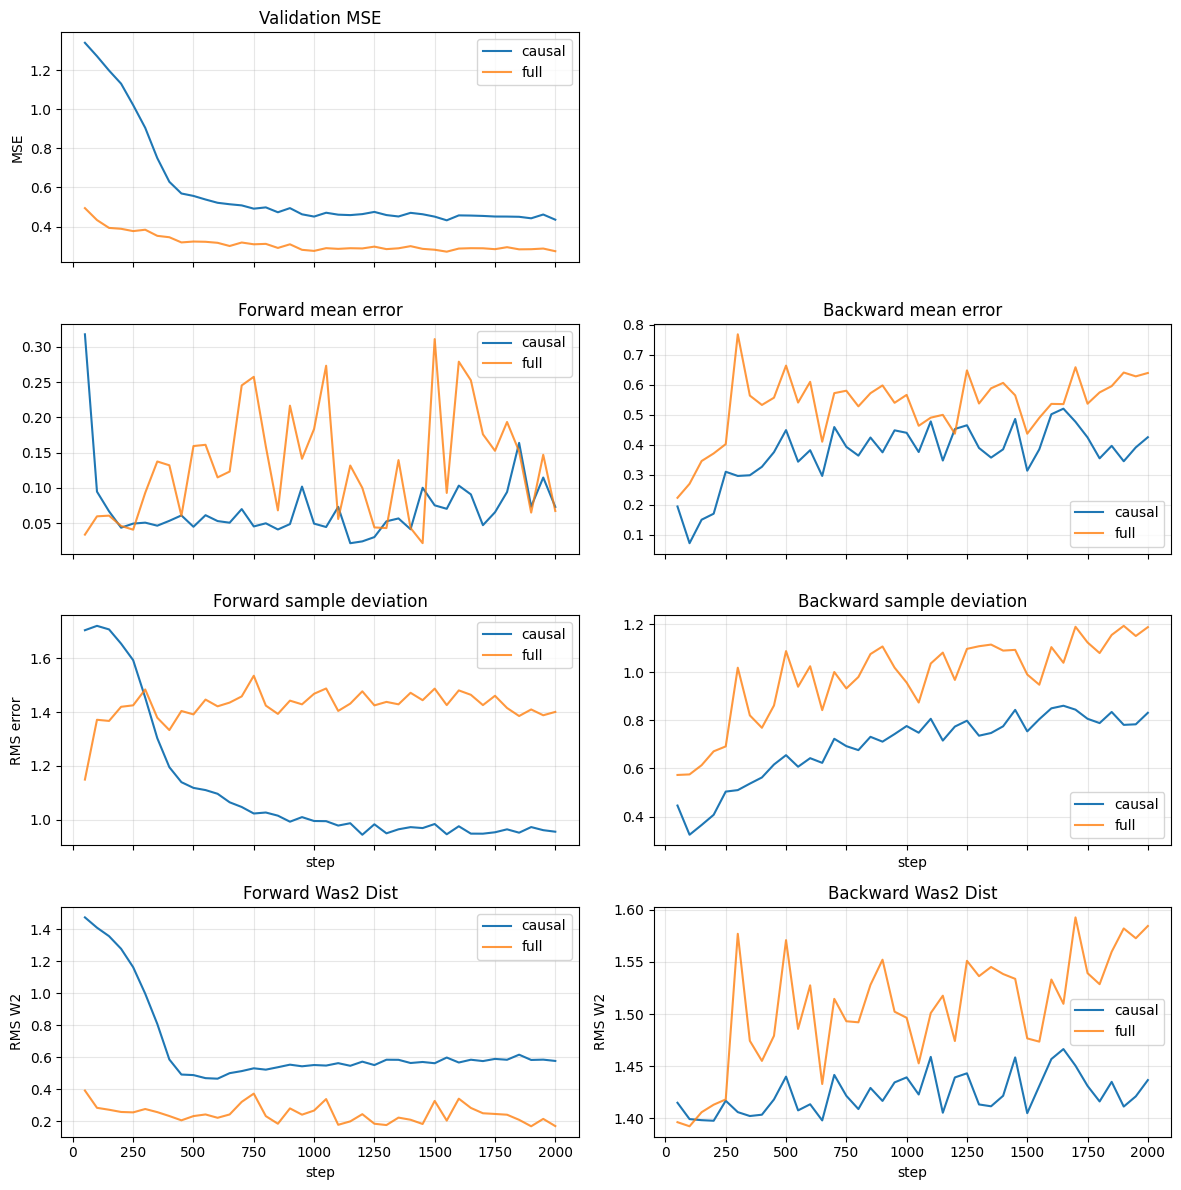

In [10]:
if not val_history:
    raise ValueError("val_history is empty – run validation before plotting.")

def flatten_val_entry(entry):
    return {
        "step": entry["step"],
        "loss_causal": entry["loss_causal"],
        "loss_full": entry["loss_full"],
        "forward_causal_mean_diff": entry["forward_stats_causal"]["mean_diff_target"],
        "forward_causal_mean_dev": entry["forward_stats_causal"]["mean_dev_target"],
        "forward_causal_w2_dist": entry["forward_stats_causal"]["w2_dist"],
        "forward_full_mean_diff": entry["forward_stats_full"]["mean_diff_target"],
        "forward_full_mean_dev": entry["forward_stats_full"]["mean_dev_target"],
        "forward_full_w2_dist": entry["forward_stats_full"]["w2_dist"],
        "backward_causal_mean_diff": entry["backward_stats_causal"]["mean_diff_prior"],
        "backward_causal_mean_dev": entry["backward_stats_causal"]["mean_dev_prior"],
        "backward_causal_w2_dist": entry["backward_stats_causal"]["w2_dist"],
        "backward_full_mean_diff": entry["backward_stats_full"]["mean_diff_prior"],
        "backward_full_mean_dev": entry["backward_stats_full"]["mean_dev_prior"],
        "backward_full_w2_dist": entry["backward_stats_full"]["w2_dist"],
    }

val_df = pd.DataFrame(flatten_val_entry(v) for v in val_history)

fig, axes = plt.subplots(4, 2, figsize=(12,12), sharex=True)
axes = axes.ravel()

axes[0].plot(val_df["step"], val_df["loss_causal"], label="causal")
axes[0].plot(val_df["step"], val_df["loss_full"], label="full", alpha=0.8)
axes[0].set_title("Validation MSE")
axes[0].set_ylabel("MSE")
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].axis("off")

axes[2].plot(val_df["step"], val_df["forward_causal_mean_diff"], label="causal")
axes[2].plot(val_df["step"], val_df["forward_full_mean_diff"], label="full", alpha=0.8)
axes[2].set_title("Forward mean error")
axes[2].grid(alpha=0.3)
axes[2].legend()

axes[3].plot(val_df["step"], val_df["backward_causal_mean_diff"], label="causal")
axes[3].plot(val_df["step"], val_df["backward_full_mean_diff"], label="full", alpha=0.8)
axes[3].set_title("Backward mean error")
axes[3].grid(alpha=0.3)
axes[3].legend()

axes[4].plot(val_df["step"], val_df["forward_causal_mean_dev"], label="causal")
axes[4].plot(val_df["step"], val_df["forward_full_mean_dev"], label="full", alpha=0.8)
axes[4].set_title("Forward sample deviation")
axes[4].set_xlabel("step")
axes[4].set_ylabel("RMS error")
axes[4].grid(alpha=0.3)
axes[4].legend()

axes[5].plot(val_df["step"], val_df["backward_causal_mean_dev"], label="causal")
axes[5].plot(val_df["step"], val_df["backward_full_mean_dev"], label="full", alpha=0.8)
axes[5].set_title("Backward sample deviation")
axes[5].set_xlabel("step")
axes[5].grid(alpha=0.3)
axes[5].legend()

axes[6].plot(val_df["step"], val_df["forward_causal_w2_dist"], label="causal")
axes[6].plot(val_df["step"], val_df["forward_full_w2_dist"], label="full", alpha=0.8)
axes[6].set_title("Forward Was2 Dist")
axes[6].set_xlabel("step")
axes[6].set_ylabel("RMS W2")
axes[6].grid(alpha=0.3)
axes[6].legend()

axes[7].plot(val_df["step"], val_df["backward_causal_w2_dist"], label="causal")
axes[7].plot(val_df["step"], val_df["backward_full_w2_dist"], label="full", alpha=0.8)
axes[7].set_title("Backward Was2 Dist")
axes[7].set_xlabel("step")
axes[7].set_ylabel("RMS W2")
axes[7].grid(alpha=0.3)
axes[7].legend()


fig.savefig(loss_plots_path, dpi=150, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [11]:
eval_batch = 2**12
time_grid = gp_sampler.times.cpu().numpy()  # assumes you still have the sampler around
gp_mean_flat, gp_cov = gp_sampler.get_stats(flatten=True)
gp_mean = gp_mean_flat.reshape(T, dim).cpu().numpy()
gp_std = torch.sqrt(torch.diagonal(gp_cov).reshape(T, dim)).cpu().numpy()

node_causal = NeuralODE(torch_wrapper(model_causal), solver="dopri5",
                        sensitivity="adjoint", atol=1e-4, rtol=1e-4)
node_full = NeuralODE(torch_wrapper(model_full), solver="dopri5",
                      sensitivity="adjoint", atol=1e-4, rtol=1e-4)

x0 = prior_sampler.sample(eval_batch).to(device)
x1_true = target_sampler.sample(eval_batch).to(device).reshape(eval_batch, T, dim).cpu().numpy()
with torch.no_grad():
    x1_causal = node_causal.trajectory(x0, t_span=torch.linspace(0, 1, 2).to(device))[-1]
    x1_full = node_full.trajectory(x0, t_span=torch.linspace(0, 1, 2).to(device))[-1]

data_causal = x1_causal.reshape(eval_batch, T, dim).cpu().numpy()
data_full = x1_full.reshape(eval_batch, T, dim).cpu().numpy()

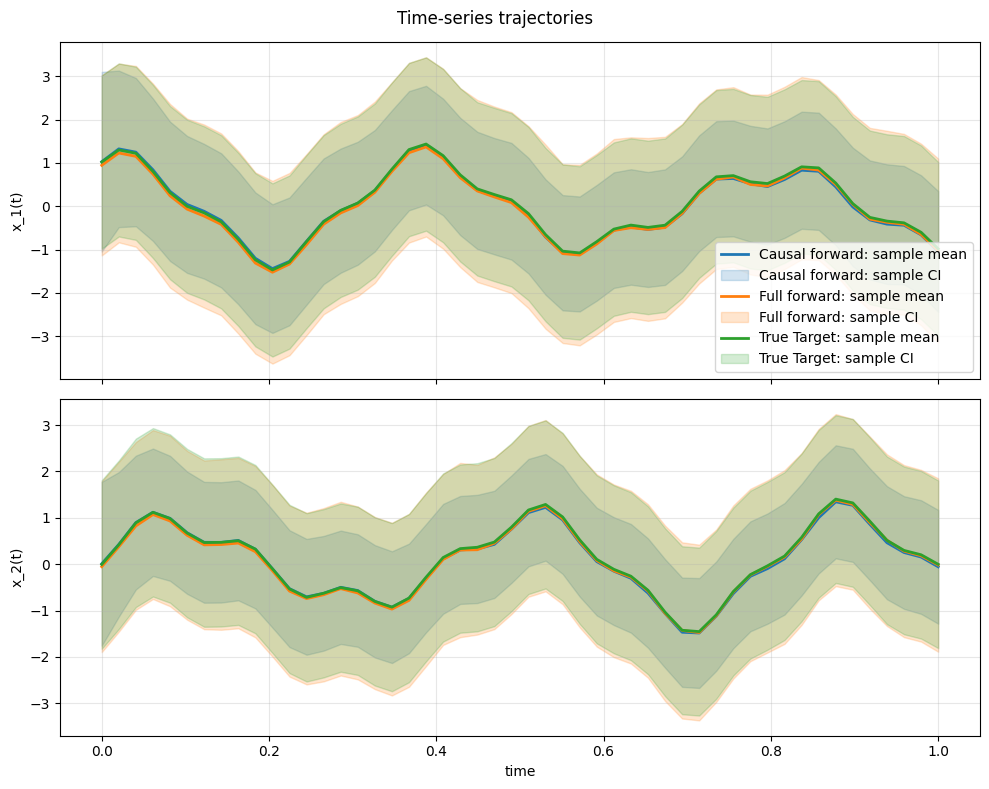

In [12]:
fig_samples = plot_time_series(
    [(time_grid, data_causal), (time_grid, data_full), (time_grid, x1_true)],
    labels=["Causal forward", "Full forward", "True Target"],
    plot_mean=True,
    plot_ci=True,
    #true_mean=[gp_mean, None],
    #true_std=[gp_std, None],
    ci_level=2.0,
    max_samples=0,
    separate_dims=True,
    figsize=(10, 4),
)

fig_samples.savefig(samples_fig_path, dpi=150, bbox_inches="tight")
plt.show()

/Users/tkargin/VSCode/conditional-flow-matching/MaskedCFM/random_processes/plotting.py:312: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


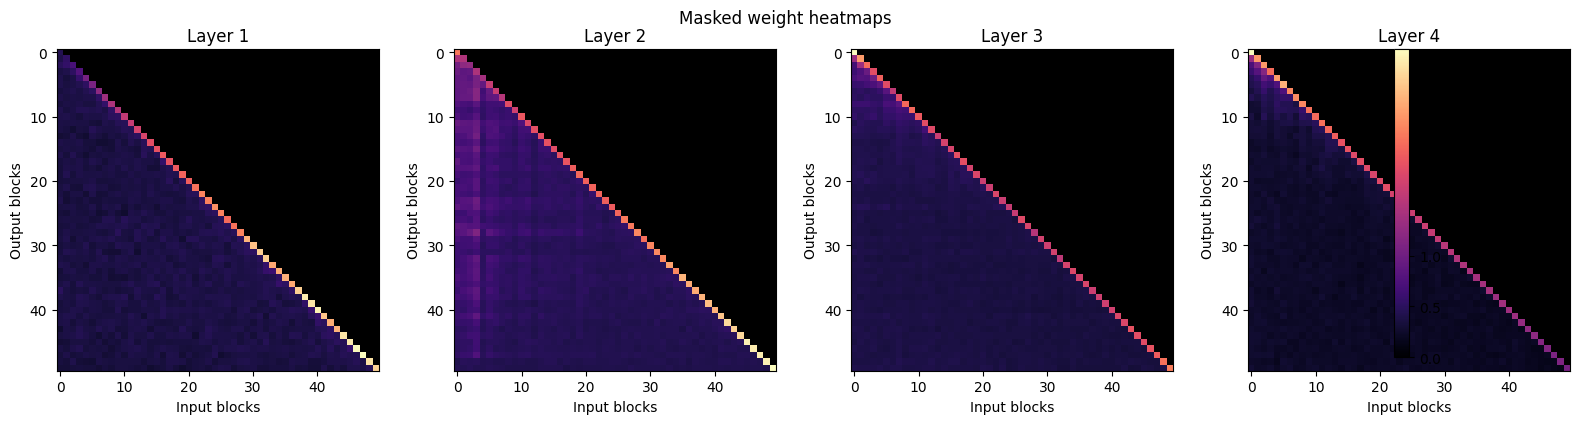

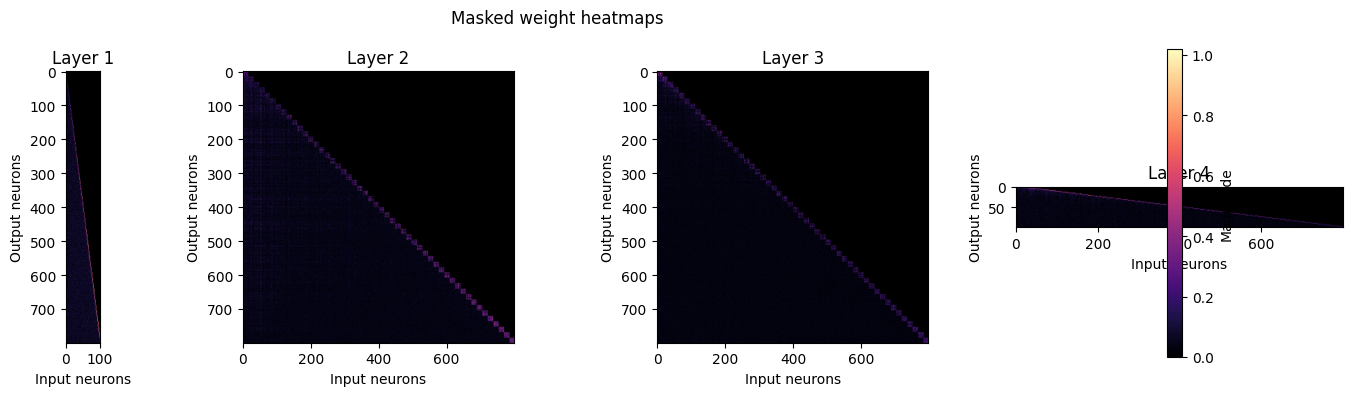

In [13]:
from importlib import reload
import random_processes.plotting as plotting

plotting = reload(plotting)  # picks up the new definition

from random_processes.plotting import plot_block_weight_heatmaps

fig_blocks = plot_block_weight_heatmaps(
    model_causal,
    mode="block",          # or "full"
    include_shared=False,
    cmap="magma",
    annotate=False,
    norm="fro",
)
fig_blocks.savefig(run_dir/"blocks_heatmap.png", dpi=150)
plt.show()

fig_weights = plot_block_weight_heatmaps(
    model_causal,
    mode="full",          # or "full"
    include_shared=False,
    cmap="magma",
    annotate=False,
    norm="fro",
)
fig_weights.savefig(run_dir/"weights_heatmap.png", dpi=150)
plt.show()

#fig = plot_block_weight_heatmaps(model_causal, include_shared=False)
#fig.savefig(run_dir / "block_weights.png", dpi=150)
#plt.show()

In [14]:
# 1) main weights/optimizers
torch.save({
    "step": num_steps,
    "model_causal": model_causal.state_dict(),
    "model_full": model_full.state_dict(),
    "optimizer_causal": optimizer_causal.state_dict(),
    "optimizer_full": optimizer_full.state_dict(),
    "prior_sampler": prior_sampler.state_dict(),
    "target_sampler": target_sampler.state_dict(),
}, run_dir / "weights.pt")


# 2) checkpoints (only store snapshots from eval steps)
torch.save(checkpoints, run_dir / "checkpoints.pt")

# 3) lightweight metadata JSON
payload = {
    "run_id": run_id,
    "timestamp": datetime.now().isoformat(),
    "training": {
        "num_steps": num_steps,
        "eval_every": eval_every,
        "batch_size": batch_size,
        "batch_val": batch_val,
        "lr_causal": lr_causal,
        "lr_full": lr_full,
    },
    "model": {
        "dim": dim,
        "T": T,
        "dim_w": dim_w,
        "num_layers": num_layers,
        "causal_hidden_per_t": list((dim_w,) * num_layers),
    },
    "histories": {
        "train": to_serializable(train_history),
        "val": to_serializable(val_history),
    },
    "figures": {
        "validation_metrics": str(loss_plots_path),
        "forward_samples": str(samples_fig_path),
    },
}
with open(run_dir / "run_meta.json", "w") as f:
    json.dump(payload, f, indent=2)

In [15]:
# with torch.no_grad():
#     for idx, layer in enumerate(model.layers):
#         if isinstance(layer, MaskedLinear):
#             print(f"\nLayer {idx}")
#             print("weight =\n", layer.weight)
#             print("mask =\n", layer.mask)
#             print("effective weight =\n", layer.weight * layer.mask)
#             if layer.bias is not None:
#                 print("bias =\n", layer.bias)

Optimal transport coupling:
$$ \pi_{\mathsf{OT}}(dx_0, dx_1) \triangleq \argmin_{\pi \in \mathscr{C}(\mathbb{Q}_0, \mathbb{Q}_1)} \frac{1}{2}\int \|x_0 - x_1\|^2 \pi(dx_0, dx_1) $$

In [16]:
# %%time
# from torchcfm.optimal_transport import OTPlanSampler

# ot_sampler = OTPlanSampler(method="exact")
# sigma = 0.1
# dim = 2
# batch_size = 256
# model = MLP(dim=dim, time_varying=True)
# optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)

# start = time.time()
# for k in range(20000):
#     optimizer.zero_grad()

#     x0 = sample_8gaussians(batch_size)
#     x1 = sample_moons(batch_size)

#     # Draw samples from OT plan
#     x0, x1 = ot_sampler.sample_plan(x0, x1)

#     t = torch.rand(x0.shape[0]).type_as(x0)
#     xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
#     ut = compute_conditional_vector_field(x0, x1)

#     vt = model(torch.cat([xt, t[:, None]], dim=-1))
#     loss = torch.mean((vt - ut) ** 2)

#     loss.backward()
#     optimizer.step()

#     if (k + 1) % 5000 == 0:
#         end = time.time()
#         print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
#         start = end
#         node = NeuralODE(
#             torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
#         )
#         with torch.no_grad():
#             traj = node.trajectory(
#                 sample_8gaussians(1024),
#                 t_span=torch.linspace(0, 1, 100),
#             )
#             plot_trajectories(traj.cpu().numpy())


